In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

## Imports

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers

## formatting

In [3]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

plt.style.use('default')
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})

## Paths and directories

In [4]:
ROOT_DIR = pathlib.Path("/content/drive/MyDrive/Research/PAPER_1_CODE")
DATA_DIR = ROOT_DIR/"geometrics_ideal_clean"

csv_header_filepath = DATA_DIR/"header.json"

train_dir = DATA_DIR/"train"
valid_dir = DATA_DIR/"valid"
test_dir = DATA_DIR/"test"

model_save_root = ROOT_DIR/"models"

In [5]:
csv_header_filepath

PosixPath('/content/drive/MyDrive/Research/PAPER_1_CODE/geometrics_ideal_clean/header.json')

In [6]:
import json
with open(csv_header_filepath, "r") as jsonfile:
  jsondata = json.load(jsonfile)
header = jsondata["headers"]

# Utils

## Modules

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense

class ResnetBlock(tf.keras.Model):
  def __init__(self, units, dropout_rate=0.001, **kwargs):
    super(ResnetBlock, self).__init__(**kwargs)

    self.units=units
    self.dropout_rate=dropout_rate
    self.dense1 = Dense(units)
    self.dense2 = Dense(units)
    self.dense3 = Dense(units)

    self.dropout = Dropout(dropout_rate)
  
  @tf.function()
  def call(self, input_tensor, training=False):
    x = self.dense1(input_tensor, training=training)
    x = self.dropout(x)
    x = self.dense2(x, training=training)
    x = self.dropout(x)
    x = self.dense3(x, training=training)
    x = self.dropout(x)

    x += input_tensor
    return tf.nn.relu(x)
  
  def get_config(self):
      config = super(ResnetBlock, self).get_config()
      config.update({"units": self.units, "dropout_rate": self.dropout_rate})
      return config

In [8]:
import tensorflow as tf

class NormalizedBaseClass(tf.keras.losses.Loss):
  def __init__(self, lb=[], up=[], indices=[], epsilon=1e-12, dtype=tf.float32, **kwargs):
    super().__init__(**kwargs)

    self.indices = indices
    self.use_indices = True if len(indices) > 0 else False

    self.epsilon = epsilon
    self.dtype = dtype

    self.lowBound = self.setBounds(lb)
    self.uppBound = self.setBounds(up)
    self.epsilon_tensor = self.setEpsilonTensor(epsilon)
    
    self._dividion_denomiator = tf.maximum(tf.subtract(self.uppBound, self.lowBound, name="denom_sub"), self.epsilon_tensor)    
  
  def setBounds(self, bd):
    return tf.constant(self.gather(bd), dtype=self.dtype)
  
  def setEpsilonTensor(self,epsilon):
    return tf.constant(self.epsilon, dtype=self.dtype, shape=self.lowBound.shape)

  def gather(self, tensor, axis=-1):
    if not self.use_indices:
      return tensor
    gathered = tf.gather(tensor, self.indices, axis=axis)
    if gathered.dtype != self.dtype:
      gathered = tf.cast(gathered, self.dtype)
    return gathered

  def normalize(self, X, gather_x=True):
    if gather_x:
      X = self.gather(X)
    S = tf.subtract(X, self.lowBound, name="norm_sub")
    return tf.divide(S, self._dividion_denomiator, name="norm_div")
  
  def convert_inputs(self, y_true, y_pred, set_dtype=True):
    y_pred = tf.convert_to_tensor(y_pred)    
    y_true = tf.cast(y_true, y_pred.dtype)
    if set_dtype:
      self.setDtype(y_pred.dtype)
    return y_true, y_pred

  def setDtype(self, dtype):
    self.dtype = dtype

  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "lb":self.lb, "up": self.up, "epsilon": self.epsilon}
  
class NormalizedMeanAbsoluteError(NormalizedBaseClass):
  def __init__(self, lb=[], up=[], indices=[], **kwargs):
    super().__init__(**kwargs)
  
  def call(self, y_true, y_pred):
    y_true, y_pred = self.convert_inputs(y_true, y_pred)
    y_true_norm, y_pred_norm = self.normalize(y_true), self.normalize(y_pred, False)
    return tf.math.reduce_mean(tf.abs(y_pred_norm - y_true_norm), axis=-1)
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "lb":self.lb, "up": self.up, "epsilon": self.epsilon}

class NormalizedMeanSquaredError(NormalizedBaseClass):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
  
  def call(self, y_true, y_pred):
    y_true, y_pred = self.convert_inputs(y_true, y_pred)
    y_true_norm, y_pred_norm = self.normalize(y_true), self.normalize(y_pred, False)
    return tf.math.reduce_mean(tf.math.square(y_pred_norm - y_true_norm), axis=-1)
  def get_config(self):
    base_config = super().get_config()
    return {**base_config, "lb":self.lb, "up": self.up, "epsilon": self.epsilon}

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense

def build_norm_layer(batch_size, header, labels, feats, name="norm",int_labels=False):
  from tensorflow.keras.layers.experimental import preprocessing
  ds_norm  = csv_ds_reader(train_dir, header, labels, feats, int_labels=int_labels, batch_size=batch_size)
  norm_layer = preprocessing.Normalization(name=name)
  for (xs, _) in ds_norm.take(1):
    norm_layer.adapt(xs)
  return norm_layer

class GAMMA_Regressor_Model(tf.keras.Model):
  def __init__(self, n_units, n_blocks, norm_layer, n_output_labels, **kwargs):
    super(GAMMA_Regressor_Model, self).__init__(**kwargs)

    self.n_units = n_units
    self.n_blocks = n_blocks
    self.norm = norm_layer

    self.d1 = Dense(self.n_units, activation="relu")
    self.l1 = [ResnetBlock(self.n_units, dropout_rate=0.001) for _ in range(n_blocks)]
    self.l2 = [ResnetBlock(self.n_units*2, dropout_rate=0.001) for _ in range(n_blocks)]
    self.l3 = [ResnetBlock(self.n_units*4, dropout_rate=0.001) for _ in range(n_blocks)]

    self.d2 = Dense(self.n_units*2, activation="relu")
    self.d3 = Dense(self.n_units*4, activation="relu")

    self.tail = [
      layers.ActivityRegularization(0.0001, 0.0001),
      Dense(n_output_labels, name="gr_body_out"),
    ]

  def call(self, input_tensor, training=False):
    x_norm = self.norm(input_tensor)
    # x = tf.concat([x_norm, x_bins], axis=1)
    x = self.d1(x_norm)
    for layer in self.l1:
      x = layer(x)
    x = self.d2(x)
    x = self.d3(x)
    for layer in self.tail:
      x = layer(x)
    return x

  def get_config(self):
      # config = super(CM4_Model, self).get_config()
      return {"n_units": self.n_units, "n_blocks": self.n_blocks}

## utils

In [10]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf

def get_indexes(header, of_keys):
  return [header[key]+1 for key in of_keys]

def csv_ds_reader(filepaths, 
                  header,
                  label_keys,
                  feature_keys,
                  int_labels=False,
                  reshape_to=None,
                  batch_size=32,
    repeat=1, n_readers=5, 
    shuffle_buffer_size=10000, 
    cache=True, 
    n_read_threads=None, 
    n_parse_threads=5):
  
  label_indexes = get_indexes(header, label_keys)
  feature_indexes = get_indexes(header, feature_keys)
  
  def get_features_labels(line):
    """
      Re-structures DS to read csv field and return 'features, labels'
    """
    defs = [0.] * (len(header) + 1) #n_labels
    fields = tf.io.decode_csv(line, record_defaults=defs)
 
    # cm-lookup -> CM1 -> (CMs), (FB, PV)
    _labels  = tf.stack([fields[i] for i in label_indexes])
    features = tf.stack([fields[i] for i in feature_indexes])
   
    try:
      tf.debugging.check_numerics(_labels, message='Checking _labels')
    except Exception as e:
      assert "Checking labels: Tensor had NaN values" in e.message
    
    try:
      tf.debugging.check_numerics(features, message='Checking features')
    except Exception as e:
      assert "Checking features: Tensor had NaN values" in e.message

    if int_labels is True:
      _labels = tf.cast(_labels, tf.int32, "label_int")

    if reshape_to is not None:
      _labels = tf.reshape(_labels, reshape_to)
  
    return features, _labels
  
  # get files
  ds = tf.data.Dataset.list_files(str(pathlib.Path(filepaths)/'*.csv'))
  # read in random order cycling through files
  ds = ds.interleave(
      lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
      cycle_length=n_readers, num_parallel_calls=n_read_threads
  )
  # shuffle and repeat
  ds = ds.shuffle(shuffle_buffer_size).repeat(repeat)
  # preprocess dataset (must provide a function)
  ds = ds.map(get_features_labels, num_parallel_calls=n_parse_threads)
  # cache dataset
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(1)
  return ds

In [11]:
import json
def save_model_info(dir, features, labels, scales=[]):
  model_info = {"features": features, "labels": labels, "scales": scales}
  model_info = json.dumps(model_info)
  if not os.path.exists(dir):
    os.makedirs(dir)
  with open(dir/"info.json", "w") as jsonfile:
    jsonfile.write(model_info)

In [12]:
import tensorflow as tf
import matplotlib 
import matplotlib.pyplot as plt

def scatter_accuracy(ys, preds):
  try:
    if ys.shape != preds.shape:
      ys = tf.reshape(ys, preds.shape)
    e = abs(ys - preds)
    fig, ax = plt.subplots(figsize=(10,10))
    cb = ax.scatter(ys, preds, c=e, cmap="jet")
    ax.grid()
    ax.set_ylabel("Predicted")
    ax.set_xlabel("True")
    ax.set_title("Accuracy scatter plot")
    fig.colorbar(cb, ax=ax)
  except:
    print("Failed generating scatter plot.")

# Model features and labels

In [13]:
MODEL_PREFIX = "IDEAL_GAMMA_REGRESSOR"

In [14]:
FEATS = ["endo", "epi", "pressure", "volume"]
LABELS = ["gamma",]
BIN_LABELS = [k + "-b" for k in FEATS if k+"-b" in header.keys()]
FEATS, BIN_LABELS, LABELS

(['endo', 'epi', 'pressure', 'volume'],
 ['endo-b', 'epi-b', 'pressure-b', 'volume-b'],
 ['gamma'])

# Gamma Regressor with 4 inputs

In [15]:
gm4_save_root = model_save_root/MODEL_PREFIX.upper()
gm4_best_save = gm4_save_root/"best"
gm4_best_save_weights = gm4_best_save/"weights"

## Load Gamma Dataset

Labels: ['gamma']

Features: ['epi', 'endo', 'pressure', 'volume']

In [16]:
BATCH_SIZE = 500
gm4_ds_train = csv_ds_reader(train_dir, header, LABELS, FEATS, batch_size=BATCH_SIZE)
gm4_ds_valid = csv_ds_reader(valid_dir, header, LABELS, FEATS, batch_size=BATCH_SIZE)
gm4_ds_test  = csv_ds_reader(test_dir,  header, LABELS, FEATS, batch_size=BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
LABELS

['gamma']

In [18]:
print("CM4 train set:")
for (features, labels) in gm4_ds_train.take(1):
  print("Features: {} \nLabels: {}".format(features[0], labels[0]))
  print("Shapes -> Features: {}, Labels: {}".format(features.shape, labels.shape))

CM4 train set:
Features: [74.00000 -70.00000 0.55000 0.92772] 
Labels: [0.13800]
Shapes -> Features: (500, 4), Labels: (500, 1)


### Normalization Layer

In [19]:
GAMMA_NormLayer = build_norm_layer(1000, header, LABELS, FEATS, MODEL_PREFIX+"_norm")

### Arquitecture

In [25]:
GAMMA_R = GAMMA_Regressor_Model(50, 1, GAMMA_NormLayer, len(LABELS))
GAMMA_R.build([None, len(FEATS)])
GAMMA_R.summary()

Model: "gamma__regressor__model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IDEAL_GAMMA_REGRESSOR_norm   multiple                 9         
 (Normalization)                                                 
                                                                 
 dense_12 (Dense)            multiple                  250       
                                                                 
 resnet_block_3 (ResnetBlock  multiple                 7650      
 )                                                               
                                                                 
 resnet_block_4 (ResnetBlock  multiple                 0 (unused)
 )                                                               
                                                                 
 resnet_block_5 (ResnetBlock  multiple                 0 (unused)
 )                                       

## Training

In [28]:
initial_learning_rate = 1e-4
GAMMA_ROptimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
GAMMA_RLoss = tf.keras.losses.MeanSquaredError()
GAMMA_R.compile(
    loss = [GAMMA_RLoss],# tf.keras.losses.MeanSquaredLogarithmicError()],
    optimizer=GAMMA_ROptimizer,
    metrics=["mse", "mae", tf.keras.metrics.RootMeanSquaredError()]
)

In [29]:
GAMMA_RCallbacks = [
  tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3, verbose=1),
  tf.keras.callbacks.EarlyStopping(patience=6, verbose=1, restore_best_weights=True),
]

In [30]:
with tf.device('/device:GPU:0'):
  gm4_TrainHistory = GAMMA_R.fit(
    gm4_ds_train,
    epochs=300, verbose=1, 
    validation_data=gm4_ds_valid,
    callbacks=GAMMA_RCallbacks
  )

Epoch 1/300
814/814 [==============================] - 148s 175ms/step - loss: 0.0016 - mse: 8.6935e-04 - mae: 0.0180 - root_mean_squared_error: 0.0295 - val_loss: 4.7808e-04 - val_mse: 8.7059e-05 - val_mae: 0.0070 - val_root_mean_squared_error: 0.0093 - lr: 1.0000e-04
Epoch 2/300
814/814 [==============================] - 5s 6ms/step - loss: 3.3944e-04 - mse: 7.6961e-05 - mae: 0.0063 - root_mean_squared_error: 0.0088 - val_loss: 2.2917e-04 - val_mse: 4.1611e-05 - val_mae: 0.0048 - val_root_mean_squared_error: 0.0065 - lr: 1.0000e-04
Epoch 3/300
814/814 [==============================] - 6s 7ms/step - loss: 2.0361e-04 - mse: 4.3621e-05 - mae: 0.0047 - root_mean_squared_error: 0.0066 - val_loss: 1.6218e-04 - val_mse: 2.3956e-05 - val_mae: 0.0037 - val_root_mean_squared_error: 0.0049 - lr: 1.0000e-04
Epoch 4/300
814/814 [==============================] - 5s 7ms/step - loss: 1.5120e-04 - mse: 2.8373e-05 - mae: 0.0037 - root_mean_squared_error: 0.0053 - val_loss: 1.2441e-04 - val_mse: 1.67

<ipython-input-31-a60ae996d876>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.gca().set_ylim(0,GAMMA_RTrainHistDf.values.max())


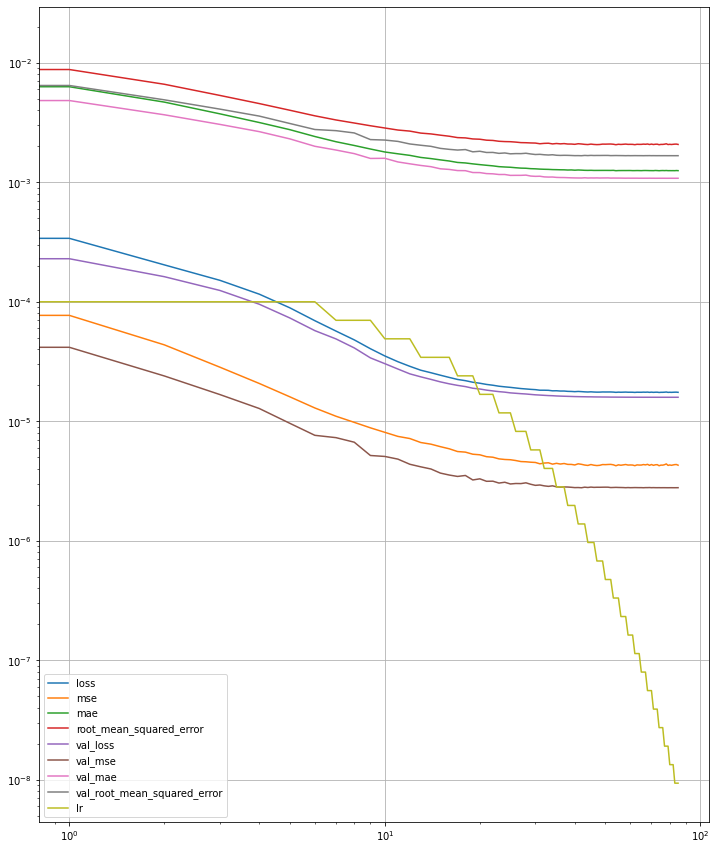

In [31]:
GAMMA_RTrainHistDf = pd.DataFrame(gm4_TrainHistory.history)
GAMMA_RTrainHistDf.plot(figsize=(12,15), logy=True, logx=True)
plt.grid(True)
plt.gca().set_ylim(0,GAMMA_RTrainHistDf.values.max())
plt.show()

## Testing

In [32]:
GAMMA_R.evaluate(gm4_ds_test)

217/217 [==============================] - 67s 280ms/step - loss: 1.5960e-05 - mse: 2.8141e-06 - mae: 0.0011 - root_mean_squared_error: 0.0017


[1.596016409166623e-05,
 2.814080289681442e-06,
 0.001079175854101777,
 0.0016775219701230526]

In [33]:
n_print = 20

for (xs, ys) in gm4_ds_test.take(1):
  preds = GAMMA_R.predict(xs)
  for i in range(n_print):
    # print("Inputs: {}".format(xs[i]))
    print("True: {} | Pred: {}".format(ys[i], preds[i]))
    # print("-"*10)

16/16 [==============================] - 0s 2ms/step
True: [0.21600] | Pred: [0.21787]
True: [0.22800] | Pred: [0.22963]
True: [0.26400] | Pred: [0.26460]
True: [0.23400] | Pred: [0.23502]
True: [0.24000] | Pred: [0.23951]
True: [0.26400] | Pred: [0.26063]
True: [0.24600] | Pred: [0.24626]
True: [0.24600] | Pred: [0.24577]
True: [0.28200] | Pred: [0.28202]
True: [0.29400] | Pred: [0.29459]
True: [0.19800] | Pred: [0.19875]
True: [0.23400] | Pred: [0.23317]
True: [0.13800] | Pred: [0.14000]
True: [0.09000] | Pred: [0.08951]
True: [0.19800] | Pred: [0.19759]
True: [0.12000] | Pred: [0.12151]
True: [0.19200] | Pred: [0.19141]
True: [0.19200] | Pred: [0.19303]
True: [0.24600] | Pred: [0.24460]
True: [0.14400] | Pred: [0.14402]


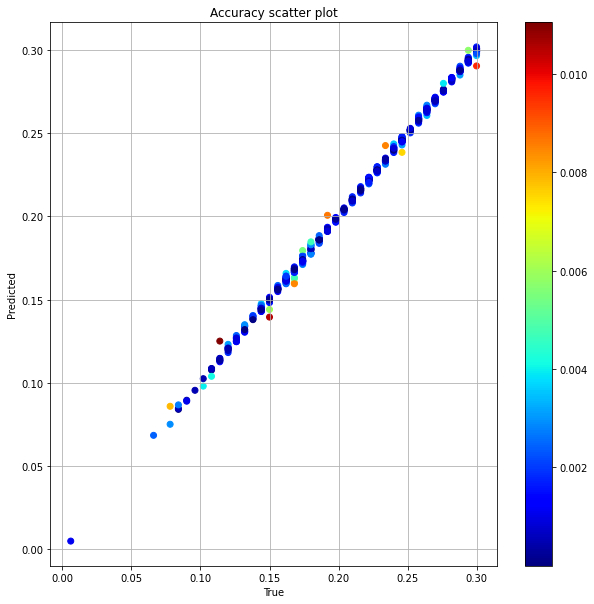

In [34]:
scatter_accuracy(ys, preds)

In [35]:
GAMMA_R.save(gm4_best_save)
GAMMA_R.save_weights(gm4_best_save_weights)

In [36]:
GAMMA_RTrainHistDf.to_csv(gm4_save_root/"train_hist.csv")